# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                        activation="relu",
                        name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax",
                             name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [19]:
## 超參數設定
"""
Set your required experiment parameters
"""
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2] #, 1e-3, 1e-4, 1e-5]
optimizers = [keras.optimizers.SGD, keras.optimizers.RMSprop]
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95


In [30]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    for optimizer in optimizers:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Experiment with LR = {lr}, optimizer = {optimizer}")
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
    
        args = {'learning_rate':lr}
        
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
                      optimizer=optimizer(**args))

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-lr-%s" % str(lr)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with LR = 0.1, optimizer = <class 'keras.optimizers.SGD'>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samp

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 248us/step - loss: 8.9224 - accuracy: 0.0987 - val_loss: 2.3037 - val_accuracy: 0.0999
Epoch 2/10
50000/50000 [==============================] - 13s 257us/step - loss: 2.3078 - accuracy: 0.0986 - val_loss: 2.3033 - val_accuracy: 0.1004
Epoch 3/10
50000/50000 [==============================] - 11s 223us/step - loss: 2.2688 - accuracy: 0.1208 - val_loss: 2.3088 - val_accuracy: 0.1373
Epoch 4/10
50000/50000 [==============================] - 11s 230us/step - loss: 2.1415 - accuracy: 0.1646 - val_loss: 2.1762 - val_accuracy: 0.1538
Epoch 5/10
50000/50000 [==============================] - 11s 225us/step - loss: 2.1204 - accuracy: 0.1743 - val_loss: 2.1099 - val_accuracy: 0.1777
Epoch 6/10
50000/50000 [==============================] - 11s 216us/step - loss: 2.1127 - accuracy: 0.1774 - val_loss: 2.0803 - val_accuracy: 0.1913
Epoch 7/10
50000/50000 [==============================] 

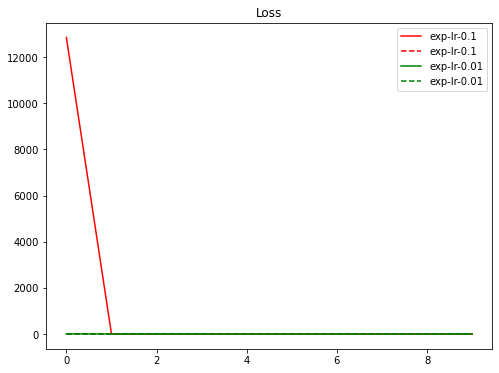

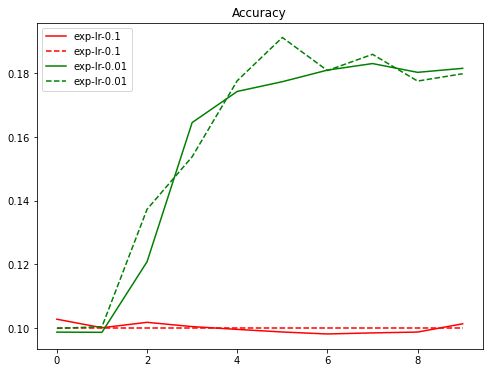

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()